In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, floatmode='fixed')

In [2]:
rng = np.random.RandomState(0)

n_samples, n_features, n_input = 70, 500, 7
freqs = np.arange(n_features)
tt = np.random.randint(10, n_features-10, n_input)
T = 8*np.random.random((n_samples, n_input))
print(tt)

[432  56 323 447 436 273 253]


In [3]:
X = np.zeros((n_samples, n_features))

for i in range(n_features):
    for j in range(n_input):
        X[:, i] += T[:,j]*np.exp( -abs(((freqs[i] - tt[j])/10)**2)) + 0.01 * rng.normal(0, 1, n_samples)

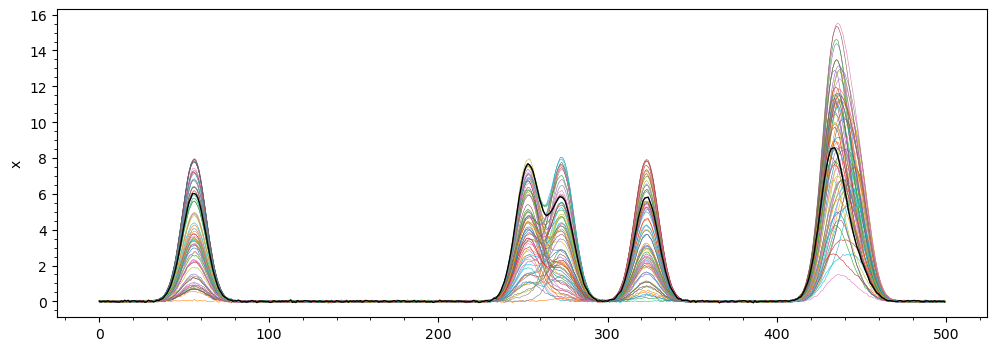

In [4]:
plt.figure(figsize=(12,4))
for k in range(n_samples):
    plt.plot(X[k], linewidth=0.4)
plt.plot(X[0], linewidth=1.0, color='k')
plt.ylabel('x')
plt.minorticks_on()
plt.show()

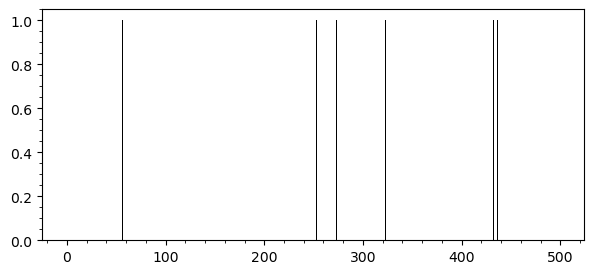

In [5]:
true_coef = np.zeros(n_features, "d")
true_x = np.sign(np.random.random(n_input))
for i,t in enumerate(tt):
    true_coef[t] = true_x[i]

plt.figure(figsize=(7,3))
plt.bar(range(n_features), true_coef, color='k')
plt.minorticks_on()
plt.show()

Y0 = X @ true_coef

In [6]:
Y = Y0 + 5.0 * rng.normal(0, 1, n_samples)

In [7]:
from mlgrad.regr import regression
from mlgrad.models import LinearModel
from mlgrad.funcs import SoftAbs_Sqrt, QuantileFunc
from mlgrad.funcs2 import AbsoluteNorm, SquareNorm, SoftAbsoluteNorm, PowerNorm
from mlgrad.loss import SquareErrorLoss, ErrorLoss
from mlgrad.gd import Masked

from sklearn.linear_model import Lasso, lars_path
from sklearn.metrics import r2_score, mean_absolute_error

In [8]:
sqrloss = SquareErrorLoss()
softabs_loss = ErrorLoss(SoftAbs_Sqrt(0.001))
l1_norm = AbsoluteNorm()
l2_norm = SquareNorm()
softabs_norm = SoftAbsoluteNorm(0.001)

Lasso: 1.186


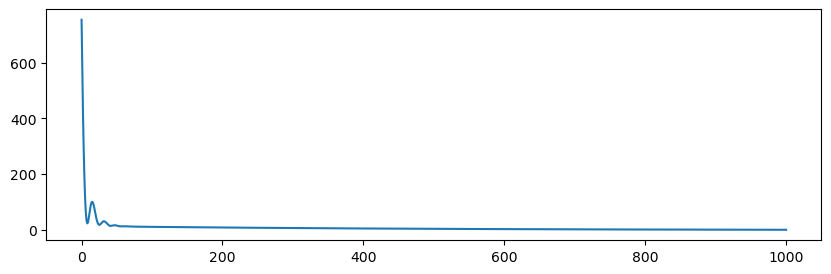

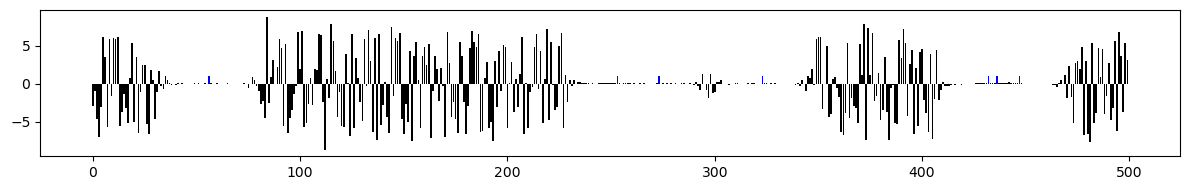

In [9]:
mod1 = LinearModel(n_features, intercept=0)
lasso1 = regression(X, Y, mod1, sqrloss, regnorm=l2_norm, 
                    # normalizer=Masked(mod1.n_param), 
                    tau=0, h=0.01)

Y_p = mod1.evaluate(X)
r2 = mean_absolute_error(Y, Y_p)
print(f"Lasso: {r2:.3f}")

plt.figure(figsize=(10,3))
plt.plot(lasso1.lvals)
plt.show()

plt.figure(figsize=(12,2))
# plt.subplot(2,1,1)
plt.bar(range(n_features), mod1.param, color='k')
plt.bar(range(n_features), true_coef, color='b')
# plt.subplot(2,1,2)
# plt.bar(range(n_features), true_coef, color='k')
# plt.xticks([])
plt.tight_layout()
plt.show()


Lasso: 3.965


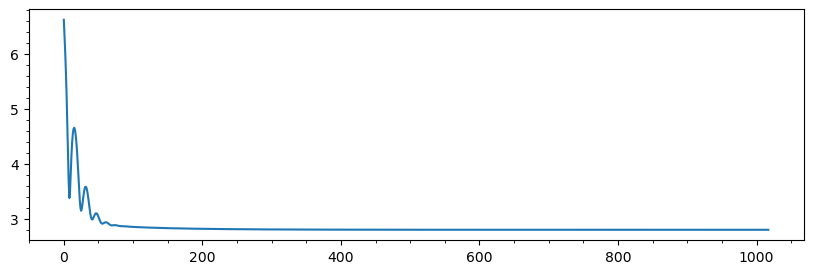

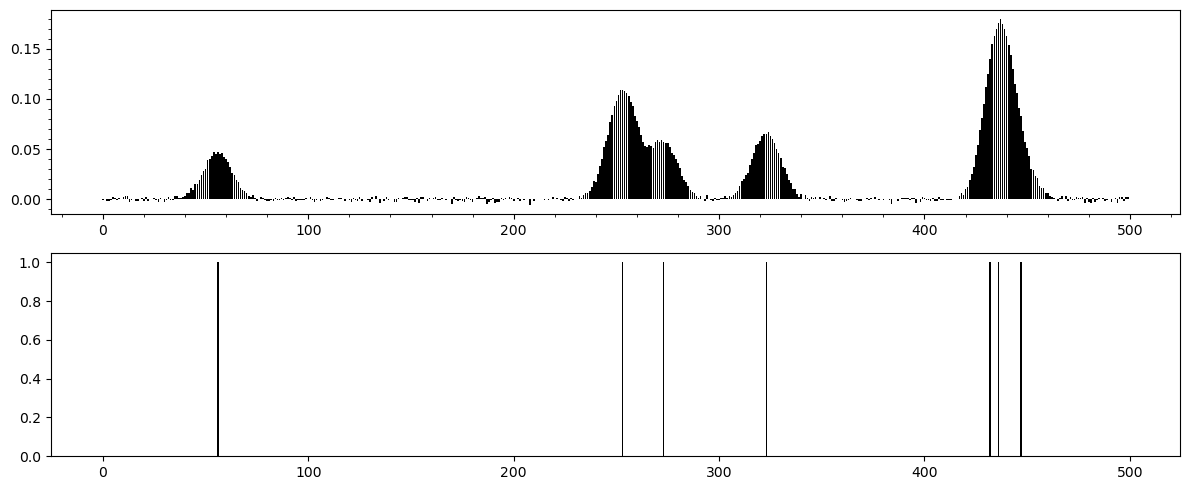

In [10]:
mod2 = LinearModel(n_features, intercept=0)
lasso2 = regression(X, Y, mod2, sqrloss, regnorm=l2_norm, #normalizer=Masked(mod2.n_param, 1.0e-4), 
                    tau=10, h=0.01, n_iter=5000, tol=1.0e-8)

Y2_p = mod2.evaluate(X)
r2 = mean_absolute_error(Y, Y2_p)
print(f"Lasso: {r2:.3f}")

plt.figure(figsize=(10,3))
plt.plot(np.log(lasso2.lvals))
plt.minorticks_on()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.bar(range(n_features), mod2.param, color='k')
# plt.bar(range(n_features), true_coef, color='b')
plt.minorticks_on()
plt.subplot(2,1,2)
plt.bar(range(n_features), true_coef, color='k')
plt.tight_layout()
plt.show()

In [11]:
import ipywidgets

In [12]:
tau_range = ipywidgets.FloatSlider(min=0.0, max=50.0, step=0.1)
@ipywidgets.interact(tau=tau_range)
def lasso_regression(tau=tau_range):
    mod2 = LinearModel(n_features, intercept=0)
    lasso2 = regression(X, Y, mod2, sqrloss,
                        regnorm=PowerNorm(1.1), 
                        normalizer=Masked(mod2.n_param, 1.0e-2), 
                        tau=tau, h=0.01, n_iter=1000, tol=1.0e-6,
                        n_restart=5)
    coeff = np.asarray(mod2.param)

    # lasso2 = Lasso(alpha=tau, fit_intercept=False)
    # lasso2.fit(X, Y)
    # coeff = lasso2.coef_
    
    Y2_p = mod2.evaluate(X)
    # Y2_p = lasso2.predict(X)
    r = mean_absolute_error(Y, Y2_p)
    
    
    plt.figure(figsize=(10,1))
    plt.title(f"tau={tau:.1f} r={r:.2f}")
    plt.plot(lasso2.lvals)
    plt.minorticks_on()
    plt.show()

    plt.figure(figsize=(12,3))
    plt.title(f"tau={tau:.1f} r={r:.2f}")
    # plt.subplot(2,1,1)
    coeff_p = coeff.copy()
    coeff_p[coeff < 0] = 0
    coeff_m = coeff.copy()
    coeff_m[coeff > 0] = 0
    plt.vlines(range(n_features), 0, coeff_p)
    plt.vlines(range(n_features), coeff_m, 0)
    plt.bar(range(n_features), true_coef, color='k')
    plt.minorticks_on()
    # plt.subplot(2,1,2)
    # plt.bar(range(n_features), true_coef, color='k')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
    plt.plot(Y2_p, marker='o', markersize=4, linewidth=0.5, label='y_p')
    plt.xlabel("t")
    plt.ylabel("y")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='tau', max=50.0), Output()), _dom_classes=('widget-in…

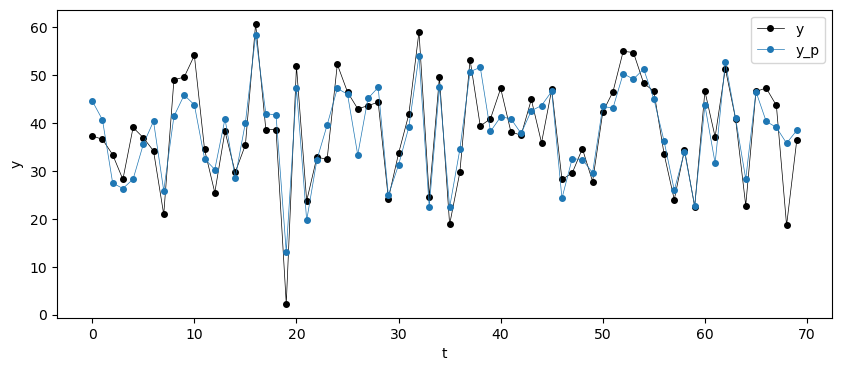

In [13]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(mod2.evaluate(X), marker='o', markersize=4, linewidth=0.5, label='y_p')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [15]:
lm_wm = LinearModel(n_features)

In [16]:
aggfunc = af.averaging_function("WM", QuantileFunc(0.79, SoftAbs_Sqrt(0.001)))
regr_wm = regr.m_regression_irls(X, Y_out, lm_wm, agg_func=aggfunc, regnorm=l1_reg, 
                                 tau=5.0, h=0.1, n_iter=5000)

plt.figure(figsize=(12,3))

plt.bar(range(n_features+1), lm_wm.param, color='k')
plt.minorticks_on()
plt.show()

NameError: name 'af' is not defined

In [ ]:
Y2_p_out = lm_wm.evaluate(X)
r2_out = r2_score(Y, Y2_p_out)
print(f"Lasso r^2: {r2_out:.3f}")

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(Y, marker='o', markersize=4, color='k', linewidth=0.5, label='y')
plt.plot(Y2_p, marker='o', markersize=4, linewidth=0.5, label='y_p')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
plt.plot(sorted(np.abs(Y2_p0-Y)), label='ols')
plt.plot(sorted(np.abs(Y2_p-Y)), label='ols_out')
plt.plot(sorted(np.abs(Y2_p_out-Y)), label='m_out')
plt.legend()
plt.show()

In [ ]:
coef_path = []
alphas = np.linspace(0.1, 7., 50)
for alpha in alphas:
    lm_wm = models.LinearModel(n_features)
    regr_wm = regr.m_regression_irls(X, Y_out, lm_wm, agg_func=aggfunc, regnorm=l1_reg, tau=alpha)
    coef_path.append(np.asarray(lm_wm.param))

coef_path = np.c_[tuple(coef_path)]

plt.figure(figsize=(12,5))
for j in range(n_features):
    plt.plot(alphas, coef_path[j,:])
plt.xlabel("alphas")
plt.ylabel("Coefficients")
plt.title("LASSO Path")

plt.show()